In [ ]:
# import datasets
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2023-04-07 04:35:44--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 404 The specified resource does not exist.
2023-04-07 04:35:45 ERROR 404: The specified resource does not exist..



In [ ]:
!ls

drive  README_rpc-cv-images.txt  rockpaperscissors.zip	runs	     scissors
paper  rock			 rps-cv-images		sample_data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [3]:
# !kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset
!kaggle datasets download -d drgfreeman/rockpaperscissors


 96% 294M/306M [00:02<00:00, 128MB/s]
100% 306M/306M [00:02<00:00, 136MB/s]


In [4]:
from zipfile import ZipFile
file_name = "/content/rockpaperscissors.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

  

Done


In [ ]:
!ls

In [60]:
import torch
import numpy as np
import torch.nn
from PIL import Image
from torchvision import transforms
import os
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import Dataset
from zipfile import ZipFile
class custom_dataset(Dataset):

    # initialize your dataset class
    def __init__(self, mode="train", tr=1, image_path="rps-cv-images", label_path="rps-cv-images"):
        self.mode = mode
        self.image_path = image_path
        self.label_path = label_path
        self.total_images = []
        self.labels = []
        self.papers = []
        self.rocks = []
        self.scissorss = []
        self.tr = tr
        self.unique_labels = []
        

        for i in os.listdir(image_path):
            class_balance = []
            self.unique_labels.append(i)
            for j in os.listdir(image_path+"/" + i):
                class_balance.append(image_path+"/"+i+"/"+j)

                self.labels.append(i)
                self.total_images.append(i+'/'+j)
            if str.lower(i) == 'paper':
                self.papers = class_balance
            elif str.lower(i) == 'rock':
                self.rocks = class_balance
            elif str.lower(i) == 'scissors':
                self.scissorss = class_balance
        print("check if dataset is balanced: ")
        print(len(self.papers), len(self.rocks),len(self.scissorss))
        print(len(self.total_images))
        print(len(self.labels))
        self.unique_labels.remove('.ipynb_checkpoints')
        print(self.unique_labels)
        
        
        # # encode the labels as integers
        # self.label_encoder = LabelEncoder()
        # self.labels = self.label_encoder.fit_transform(self.labels)
        
        np.random.seed(42)

        # Combine the image paths and labels into arrays
        total_images = np.array(self.total_images)
        labels = np.array(self.labels)
        # print(type(total_images))
        # print(type(labels))
        # Generate a random permutation of the indices
        
        indices = np.random.permutation(len(total_images))

        # Shuffle the images and labels arrays using the permuted indices
        shuffled_images = total_images[indices]
        shuffled_labels = labels[indices]
        # Shuffle the images and labels using a random state
        #distribute to val train and test


        train_size = 1750
        val_size = 219
        test_size = 219


        # Split the dataset into training (22,000), testing (2,000), and validation (1,000) sets
        train_images = shuffled_images[:train_size]
        train_labels=shuffled_labels[:train_size]

        test_images = shuffled_images[train_size:train_size+test_size]
        test_labels = shuffled_labels[train_size:train_size+test_size]

        val_images = shuffled_images[train_size+test_size:]
        val_labels = shuffled_labels[train_size+test_size:]



        if(self.mode == "train"):
            self.image_list = train_images
            self.labels = train_labels
        elif(self.mode == "val"):
            self.image_list = val_images
            self.labels = val_labels
        elif(self.mode == "test"):
            self.image_list = test_images
            self.labels = test_labels

        

    def __getitem__(self, index):
        

        image = Image.open(self.image_path+'/'+self.image_list[index])
        label = self.labels[index]
        # print(label)
        # print(self.unique_labels)
        label = self.parse_labels(label)
        # print(label)
        # Convert the image to RGB scale
        image = image.convert('RGB')
        
        # image.show()
          

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        

        # Data augmentation transformations
        augmentation_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        ])
        # Create a transformation that normalizes the image
        transform = transforms.Compose([
            transforms.Resize(
            (224, 224), interpolation=transforms.InterpolationMode.NEAREST),# Resize the image to 224x224
            transforms.CenterCrop(size=(224, 224)),   
            transforms.ToTensor(),           # Convert the image to a tensor
            transforms.Normalize(mean, std)  # Normalize the image
        ])

        if(self.tr):
            image = augmentation_transforms(image)
        
        
        
        image = transform(image)
        

        return image, label
    
    
    def parse_labels(self, label):
        arr = np.zeros((len(self.unique_labels),), dtype= float)
        for i in range(len(self.unique_labels)):
            if label == self.unique_labels[i]:
                arr[i] = 1.0
        return arr
    


    def __len__(self):
        return len(self.image_list)
        # return None


custom_dataset()[1]
# print(self.label)
# cat is 0 and dog is 1


check if dataset is balanced: 
712 726 750
2188
2188
['paper', 'scissors', 'rock']


(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [ ]:
# VGG 16 model

In [62]:
import torch.nn as nn
import torchvision.models as models
vgg16=models.vgg16(pretrained=True)
vgg16.classifier[6]=nn.Linear(4096,3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 17.0 MB/s eta 0:00:00


In [10]:
from torchmetrics.classification import MulticlassF1Score
import torch


def metrics(preds, target):
    metr = MulticlassF1Score(num_classes=3)

    return metr(preds, target)



In [76]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
from torch.nn.functional import cross_entropy
from torchmetrics import F1Score


from torch.utils.data import DataLoader, Dataset
# from models.example_model import ExModel
# from datasets.dataset_retrieval import custom_dataset
from torch.optim import SGD, Adam
from torch.utils.tensorboard import SummaryWriter
import tqdm

import os

save_model_path = "checkpoints/"
pth_name = "saved_model.pth"




def val(model, data_val, loss_function, writer, epoch):
    f1score = 0
    f1 = F1Score(num_classes=3, task = 'multiclass')
    data_iterator = enumerate(data_val)  # take batches
    f1_list = []
    f1t_list = []

    with torch.no_grad():
        model.eval()  # switch model to evaluation mode
        tq = tqdm.tqdm(total=len(data_val))
        tq.set_description('Validation:')

        total_loss = 0

        for _, batch in data_iterator:
            # forward propagation
            image, label = batch
            image = image.cuda()
            label = label.cuda()
            pred = model(image)

            loss = loss_function(pred, label.float())
            loss = loss.cuda()

            pred = pred.softmax(dim=1)
            
            f1_list.extend(torch.argmax(pred, dim =1).tolist())
            f1t_list.extend(torch.argmax(label, dim =1).tolist())
            #f1score += f1_score(label.squeeze().detach().cpu(), pred.squeeze().detach().cpu())

            total_loss += loss.item()
            tq.update(1)

    writer.add_scalar("Validation mIoU", f1score/len(data_val), epoch)
    writer.add_scalar("Validation Loss", total_loss/len(data_val), epoch)


    tq.close()
    print("F1 score: ", f1(torch.tensor(f1_list), torch.tensor(f1t_list)))


    return None


def train(model, dataloader, val_loader, optimizer, loss_fn, n_epochs):
    device = 'cuda'
    writer = SummaryWriter()

    model.cuda()  # Move the model to the specified device (e.g., GPU or CPU)
    model.train()  # Set the model to training mode
    for epoch in range(n_epochs):
        running_loss = 0.0
        tq = tqdm.tqdm(total=len(dataloader))
        tq.set_description('epoch %d' % (epoch))
        f1score = 0

        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)  # Move the batch of images to the specified device
            labels = labels.to(device)  # Move the batch of labels to the specified device
            
            optimizer.zero_grad()  # Reset the gradients of the optimizer
            
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = loss_fn(outputs, labels)
            outputs = outputs.softmax(dim=1)

            # Backward pass
            loss.backward()
            #f1score += f1_score(labels.detach().cpu(), outputs.detach().cpu())

            # Update model parameters
            optimizer.step()
            
            running_loss += loss.item()
            tq.set_postfix(loss_st='%.6f' % loss.item())
            tq.update(1)
        tq.close()
        epoch_loss = running_loss / len(dataloader)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, epoch_loss))
        
        print(f1score/len(dataloader))
        
        
        val(model, val_loader, loss_fn, writer, epoch)
        
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }

        torch.save(checkpoint, os.path.join(save_model_path, pth_name))
        print("saved the model " + save_model_path)
        model.train()

train_data = custom_dataset("train")
val_data = custom_dataset("val")

train_loader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    val_data,
    batch_size=64
)

# model = ExModel(3).cuda()   # Initialsing an object of the class.

optimizer = SGD(vgg16.parameters(),  lr=0.0001)
# optimizer = Adam(vgg16.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()


# if you want to load your pretrained model or
# you want to resume stopped training
# use torch.load_state_dict by checking the library!


train(vgg16, train_loader, val_loader,  optimizer,loss, 5)

check if dataset is balanced: 
712 726 750
2188
2188
['paper', 'scissors', 'rock']
check if dataset is balanced: 
712 726 750
2188
2188
['paper', 'scissors', 'rock']


epoch 0: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it, loss_st=0.262128]


Epoch [1/5], Loss: 0.3216
0.0


Validation:: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


F1 score:  tensor(0.9726)
saved the model checkpoints/


epoch 1: 100%|██████████| 28/28 [00:41<00:00,  1.47s/it, loss_st=0.274608]


Epoch [2/5], Loss: 0.2799
0.0


Validation:: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


F1 score:  tensor(0.9772)
saved the model checkpoints/


epoch 2: 100%|██████████| 28/28 [00:40<00:00,  1.46s/it, loss_st=0.322407]


Epoch [3/5], Loss: 0.2508
0.0


Validation:: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


F1 score:  tensor(0.9909)
saved the model checkpoints/


epoch 3: 100%|██████████| 28/28 [00:40<00:00,  1.45s/it, loss_st=0.178153]


Epoch [4/5], Loss: 0.2201
0.0


Validation:: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


F1 score:  tensor(0.9863)
saved the model checkpoints/


epoch 4: 100%|██████████| 28/28 [00:40<00:00,  1.46s/it, loss_st=0.193553]


Epoch [5/5], Loss: 0.2005
0.0


Validation:: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


F1 score:  tensor(0.9817)
saved the model checkpoints/


In [77]:
# Load the state dictionary from the saved checkpoint into the model
saved_checkpoint = torch.load(os.path.join(save_model_path, pth_name))
vgg16.load_state_dict(saved_checkpoint['state_dict'])

<All keys matched successfully>

In [78]:

test_data = custom_dataset("test")


test_loader = DataLoader(
    test_data,
    batch_size=64
)


def test(model, data_test, loss_function):
    f1score = 0
    f1 = F1Score(num_classes=3, task = 'multiclass')
    data_iterator = enumerate(data_test)  # take batches
    f1_list = []
    f1t_list = []

    with torch.no_grad():
        model.eval()  # switch model to evaluation mode
        tq = tqdm.tqdm(total=len(data_test))
        tq.set_description('Testing:')

        total_loss = 0

        for _, batch in data_iterator:
            # forward propagation
            image, label = batch
            image = image.cuda()
            label = label.cuda()
            pred = model(image)

            loss = loss_function(pred, label.float())
            loss = loss.cuda()

            pred = pred.softmax(dim=1)
            
            f1_list.extend(torch.argmax(pred, dim =1).tolist())
            f1t_list.extend(torch.argmax(label, dim =1).tolist())
            #f1score += f1_score(label.squeeze().detach().cpu(), pred.squeeze().detach().cpu())

            total_loss += loss.item()
            tq.update(1)

 
    tq.close()
    print("F1 score: ", f1(torch.tensor(f1_list), torch.tensor(f1t_list)))


    return None



test(vgg16, test_loader, loss)

check if dataset is balanced: 
712 726 750
2188
2188
['paper', 'scissors', 'rock']


Testing:: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

F1 score:  tensor(0.9589)


Saving 1_FnkQhOGXoRNmYFnPO3gWNA.jpg to 1_FnkQhOGXoRNmYFnPO3gWNA (1).jpg




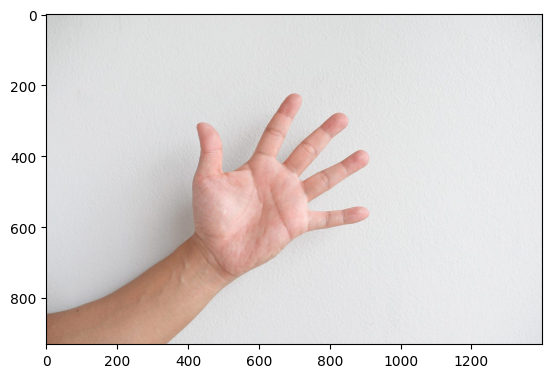


Image prediction result:  Paper
Probability:  67.05 %




In [80]:
# important section


import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved VGG16 model
# model = torch.load('path/to/saved/model.pt')

# Define the preprocessing steps for the input image
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Use the following code to upload an image
from google.colab import files
uploaded = files.upload()

# Loop through the uploaded images
for fn in uploaded.keys():
  # Load the image using PIL
  img = Image.open(fn)
  
  # Apply the preprocessing steps defined above
  img = transform(img)
  img = img.unsqueeze(0)

  # Make the prediction using the VGG16 model
  with torch.no_grad():
      outputs = vgg16(img.cuda())
      _, predicted = torch.max(outputs, 1)
      predict_proba = torch.nn.functional.softmax(outputs, dim=1)[0][predicted]
  
  # Print the predicted label and probability
  if predicted.item() == 0:
      predict_label = 'Paper'
  elif predicted.item() == 1:
      predict_label = 'Rock'
  elif predicted.item() == 2:
      predict_label = 'Scissor'
  
  print('\n')
  plt.imshow(Image.open(fn))
  plt.show()
  print("\nImage prediction result: ", predict_label)
  print("Probability: ", round(predict_proba.item()*100,2), "%")
  print('\n')


In [ ]:
# RESNET 18 model

In [67]:
resnet18=models.resnet18(pretrained=True)
resnet18.fc=nn.Linear(512,3)

In [68]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [73]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
from torch.nn.functional import cross_entropy
from torchmetrics import F1Score


from torch.utils.data import DataLoader, Dataset
# from models.example_model import ExModel
# from datasets.dataset_retrieval import custom_dataset
from torch.optim import SGD, Adam
from torch.utils.tensorboard import SummaryWriter
import tqdm

import os

save_model_path = "checkpoints/"
pth_name = "saved_model.pth"




def val(model, data_val, loss_function, writer, epoch):
    f1score = 0
    f1 = F1Score(num_classes=3, task = 'multiclass')
    data_iterator = enumerate(data_val)  # take batches
    f1_list = []
    f1t_list = []

    with torch.no_grad():
        model.eval()  # switch model to evaluation mode
        tq = tqdm.tqdm(total=len(data_val))
        tq.set_description('Validation:')

        total_loss = 0

        for _, batch in data_iterator:
            # forward propagation
            image, label = batch
            image = image.cuda()
            label = label.cuda()
            pred = model(image)

            loss = loss_function(pred, label.float())
            loss = loss.cuda()

            pred = pred.softmax(dim=1)
            
            f1_list.extend(torch.argmax(pred, dim =1).tolist())
            f1t_list.extend(torch.argmax(label, dim =1).tolist())
            #f1score += f1_score(label.squeeze().detach().cpu(), pred.squeeze().detach().cpu())

            total_loss += loss.item()
            tq.update(1)

    writer.add_scalar("Validation mIoU", f1score/len(data_val), epoch)
    writer.add_scalar("Validation Loss", total_loss/len(data_val), epoch)


    tq.close()
    print("F1 score: ", f1(torch.tensor(f1_list), torch.tensor(f1t_list)))


    return None


def train(model, dataloader, val_loader, optimizer, loss_fn, n_epochs):
    device = 'cuda'
    writer = SummaryWriter()

    model.cuda()  # Move the model to the specified device (e.g., GPU or CPU)
    model.train()  # Set the model to training mode
    for epoch in range(n_epochs):
        running_loss = 0.0
        tq = tqdm.tqdm(total=len(dataloader))
        tq.set_description('epoch %d' % (epoch))
        f1score = 0

        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)  # Move the batch of images to the specified device
            labels = labels.to(device)  # Move the batch of labels to the specified device
            
            optimizer.zero_grad()  # Reset the gradients of the optimizer
            
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = loss_fn(outputs, labels)
            outputs = outputs.softmax(dim=1)

            # Backward pass
            loss.backward()
            #f1score += f1_score(labels.detach().cpu(), outputs.detach().cpu())

            # Update model parameters
            optimizer.step()
            
            running_loss += loss.item()
            tq.set_postfix(loss_st='%.6f' % loss.item())
            tq.update(1)
        tq.close()
        epoch_loss = running_loss / len(dataloader)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, epoch_loss))
        
        print(f1score/len(dataloader))
        
        
        val(model, val_loader, loss_fn, writer, epoch)
        
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }

        torch.save(checkpoint, os.path.join(save_model_path, pth_name))
        print("saved the model " + save_model_path)
        model.train()

train_data = custom_dataset("train")
val_data = custom_dataset("val")

train_loader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    val_data,
    batch_size=64
)

# model = ExModel(3).cuda()   # Initialsing an object of the class.

optimizer = SGD(resnet18.parameters(),  lr=0.0001)
# optimizer = Adam(resnet18.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()


# if you want to load your pretrained model or
# you want to resume stopped training
# use torch.load_state_dict by checking the library!


train(resnet18, train_loader, val_loader,  optimizer,loss, 5)

check if dataset is balanced: 
712 726 750
2188
2188
['paper', 'scissors', 'rock']
check if dataset is balanced: 
712 726 750
2188
2188
['paper', 'scissors', 'rock']


epoch 0: 100%|██████████| 28/28 [00:23<00:00,  1.19it/s, loss_st=0.659429]


Epoch [1/5], Loss: 0.6821
0.0


Validation:: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


F1 score:  tensor(0.8493)
saved the model checkpoints/


epoch 1: 100%|██████████| 28/28 [00:22<00:00,  1.23it/s, loss_st=0.660675]


Epoch [2/5], Loss: 0.6643
0.0


Validation:: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


F1 score:  tensor(0.8858)
saved the model checkpoints/


epoch 2: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s, loss_st=0.809072]


Epoch [3/5], Loss: 0.6580
0.0


Validation:: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


F1 score:  tensor(0.8676)
saved the model checkpoints/


epoch 3: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s, loss_st=0.628737]


Epoch [4/5], Loss: 0.6345
0.0


Validation:: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


F1 score:  tensor(0.8995)
saved the model checkpoints/


epoch 4: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s, loss_st=0.531494]


Epoch [5/5], Loss: 0.6080
0.0


Validation:: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

F1 score:  tensor(0.8767)
saved the model checkpoints/


In [74]:
saved_checkpoint = torch.load(os.path.join(save_model_path, pth_name))

resnet18.load_state_dict(saved_checkpoint['state_dict'])

<All keys matched successfully>

In [75]:

test_data = custom_dataset("test")


test_loader = DataLoader(
    test_data,
    batch_size=64
)


def test(model, data_test, loss_function):
    f1score = 0
    f1 = F1Score(num_classes=3, task = 'multiclass')
    data_iterator = enumerate(data_test)  # take batches
    f1_list = []
    f1t_list = []

    with torch.no_grad():
        model.eval()  # switch model to evaluation mode
        tq = tqdm.tqdm(total=len(data_test))
        tq.set_description('Testing:')

        total_loss = 0

        for _, batch in data_iterator:
            # forward propagation
            image, label = batch
            image = image.cuda()
            label = label.cuda()
            pred = model(image)

            loss = loss_function(pred, label.float())
            loss = loss.cuda()

            pred = pred.softmax(dim=1)
            
            f1_list.extend(torch.argmax(pred, dim =1).tolist())
            f1t_list.extend(torch.argmax(label, dim =1).tolist())
            # print(pred)
            # print(label)
            # print('------')
            #f1score += f1_score(label.squeeze().detach().cpu(), pred.squeeze().detach().cpu())

            total_loss += loss.item()
            tq.update(1)

    
    tq.close()
    print("F1 score: ", f1(torch.tensor(f1_list), torch.tensor(f1t_list)))
    print(f1_list)
    print(f1t_list)
    print('------')

    return None



test(resnet18, test_loader, loss)

check if dataset is balanced: 
712 726 750
2188
2188
['paper', 'scissors', 'rock']


Testing:: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

F1 score:  tensor(0.8904)
[2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 2, 0, 0, 1, 1, 1, 2, 2, 0, 1, 2, 0, 1, 1, 1, 0, 2, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 1, 0, 1, 2, 2, 1, 0, 0, 1, 1, 2, 1, 0, 0, 2, 1, 2, 1, 1, 0, 2, 1, 2, 1, 0, 2, 2, 1, 0, 1, 1, 2, 1, 1, 0, 2, 1, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 1, 2, 0, 2, 1, 2, 0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0, 2, 2, 0, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 0, 0, 2, 1, 0, 0, 1, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 0, 0, 2, 2, 0, 0, 1, 1, 0, 0, 2, 0, 1, 2, 0, 2]
[2, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 0, 2, 0, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 0, 1, 1, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 0, 0, 2, 1, 2, 1, 1, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 1, 1, 0, 0, 

Saving istockphoto-525694513-612x612.jpg to istockphoto-525694513-612x612 (3).jpg




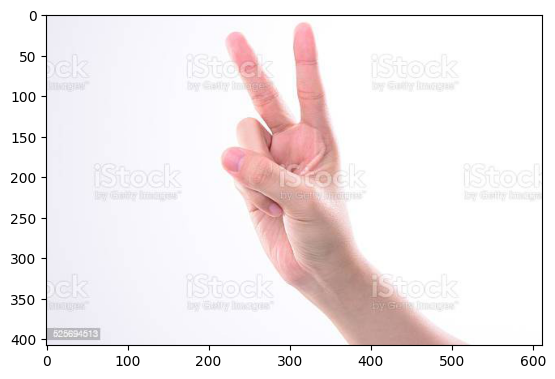


Image prediction result:  Scissor
Probability:  66.98 %




In [81]:
# important section


import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved VGG16 model
# model = torch.load('path/to/saved/model.pt')
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Define the preprocessing steps for the input image
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Use the following code to upload an image
from google.colab import files
uploaded = files.upload()

# Loop through the uploaded images
for fn in uploaded.keys():
  # Load the image using PIL
  img = Image.open(fn)
  
  # Apply the preprocessing steps defined above
  img = transform(img)
  img = img.unsqueeze(0)

  # Make the prediction using the VGG16 model
  with torch.no_grad():
      outputs = resnet18(img.cuda())
      _, predicted = torch.max(outputs, 1)
      predict_proba = torch.nn.functional.softmax(outputs, dim=1)[0][predicted]
  
  # Print the predicted label and probability
  if predicted.item() == 0:
      predict_label = 'Paper'
  elif predicted.item() == 1:
      predict_label = 'Rock'
  elif predicted.item() == 2:
      predict_label = 'Scissor'
  
  print('\n')
  plt.imshow(Image.open(fn))
  plt.show()
  print("\nImage prediction result: ", predict_label)
  print("Probability: ", round(predict_proba.item()*100,2), "%")
  print('\n')
